In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
plt.figure(figsize=(40, 10))

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, train_test_split
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
import catboost as ct
import xgboost as xgb

from sklearn.metrics import roc_auc_score

plt.figure(figsize=(40, 10))

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

In [35]:
df_train = pd.read_excel('data/Data_Train.xlsx')
df_test = pd.read_excel('data/Test_set.xlsx')

In [36]:
size_train_df = df_train.shape[0]
y_train = df_train['Price'].values
df = pd.concat((df_train, df_test)).reset_index(drop=True)

In [37]:
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0
...,...,...,...,...,...,...,...,...,...,...,...
13349,Air India,6/06/2019,Kolkata,Banglore,CCU → DEL → BLR,20:30,20:25 07 Jun,23h 55m,1 stop,No info,NaN
13350,IndiGo,27/03/2019,Kolkata,Banglore,CCU → BLR,14:20,16:55,2h 35m,non-stop,No info,NaN
13351,Jet Airways,6/03/2019,Delhi,Cochin,DEL → BOM → COK,21:50,04:25 07 Mar,6h 35m,1 stop,No info,NaN
13352,Air India,6/03/2019,Delhi,Cochin,DEL → BOM → COK,04:00,19:15,15h 15m,1 stop,No info,NaN


IndexError: index 0 is out of bounds for axis 0 with size 0

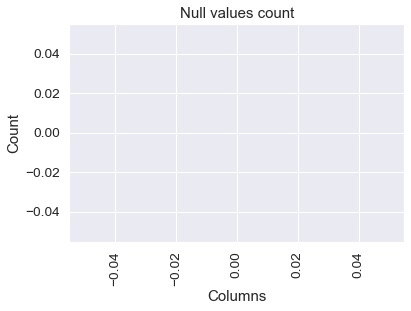

In [74]:
null_count = df.isna().sum().sort_values(ascending=False)

plt.title('Null values count')
plt.xlabel('Columns')
plt.ylabel('Count')
null_count[null_count > 0].plot(kind='bar');

In [39]:
# Рзделяю дату отправки на три фичи для более лучшего переваривания моделью
df['Data'] = df['Date_of_Journey'].str.split('/').str[0]
df['Month'] = df['Date_of_Journey'].str.split('/').str[1]
df['Year'] = df['Date_of_Journey'].str.split('/').str[2]

df.drop(['Date_of_Journey'], axis=1, inplace=True)

In [40]:
# Разделаю места пересадки на отдельные фичи, чтобы было понятнее
df['Route_0'] = df['Route'].str.split('→ ').str[0]
df['Route_1'] = df['Route'].str.split('→ ').str[1]
df['Route_2'] = df['Route'].str.split('→ ').str[2]
df['Route_3'] = df['Route'].str.split('→ ').str[3]
df['Route_4'] = df['Route'].str.split('→ ').str[4]
df['Route_5'] = df['Route'].str.split('→ ').str[5]

df.drop(['Route'], axis=1, inplace=True)

In [41]:
# Разделяю время отправка на две фичи
df['Dep_hour'] = df['Dep_Time'].str.split(':').str[0]
df['Dep_minute'] = df['Dep_Time'].str.split(':').str[0]

df.drop(['Dep_Time'], axis=1, inplace=True)

In [42]:
# Разделяю время прибытия
df['Arrival_hour'] = df['Arrival_Time'].str.split(':').str[0]
df['Arrival_minute'] = df['Arrival_Time'].str.split(':').str[1]
df['Arrival_minute'] = df['Arrival_minute'].str.split(' ').str[0]

df.drop(['Arrival_Time'], axis=1, inplace=True)

In [43]:
# Разделяю время полет(вместе с пересадками)
df['Duration_hour'] = df['Duration'].str.split(' ').str[0]
df['Duration_hour'] = df['Duration_hour'].str.split('h').str[0]
df['Duration_minute'] = df['Duration'].str.split(' ').str[1]
df['Duration_minute'] = df['Duration_minute'].str.split('m').str[0]

df.drop(['Duration'], axis=1, inplace=True)

In [44]:
df['Total_Stops'] = df['Total_Stops'].replace('non-stop', '0 stop')
df['Total_Stops'] = df['Total_Stops'].str.split(' ').str[0]

In [45]:
# Меняем, тип данных у фичей на те, которые им больше к лицу
df['Data'] = df['Data'].astype('int32')
df['Total_Stops'] = df['Data'].astype('int32')
df['Month'] = df['Data'].astype('int32')
df['Year'] = df['Data'].astype('int32')
df['Dep_hour'] = df['Data'].astype('int32')
df['Dep_minute'] = df['Data'].astype('int32')
df['Arrival_hour'] = df['Data'].astype('int32')
df['Arrival_minute'] = df['Data'].astype('int32')
df['Duration_hour'] = df['Data'].astype('int32')
df['Duration_minute'] = df['Data'].astype('int32')

In [46]:
# Ко всем категориальными переменным примения LabelEncoder для улучшения понимания моделью
cols = ['Airline', 'Source', 'Destination', 'Additional_Info', 'Route_0', 'Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5']
label_e = LabelEncoder()
for i in range(0, len(cols)):
    df[cols[i]] = label_e.fit_transform(df[cols[i]])
df

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Data,Month,Year,Route_0,...,Route_2,Route_3,Route_4,Route_5,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hour,Duration_minute
0,3,0,5,24,8,3897.0,24,24,24,0,...,30,13,5,1,24,24,24,24,24,24
1,1,3,0,1,8,7662.0,1,1,1,2,...,1,3,5,1,1,1,1,1,1,1
2,4,2,1,9,8,13882.0,9,9,9,3,...,4,5,5,1,9,9,9,9,9,9
3,3,3,0,12,8,6218.0,12,12,12,2,...,3,13,5,1,12,12,12,12,12,12
4,3,0,5,1,8,13302.0,1,1,1,0,...,8,13,5,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13349,1,3,0,6,8,NaN,6,6,6,2,...,3,13,5,1,6,6,6,6,6,6
13350,3,3,0,27,8,NaN,27,27,27,2,...,30,13,5,1,27,27,27,27,27,27
13351,4,2,1,6,8,NaN,6,6,6,3,...,6,13,5,1,6,6,6,6,6,6
13352,1,2,1,6,8,NaN,6,6,6,3,...,6,13,5,1,6,6,6,6,6,6


In [47]:
# Выбрасываю выбросы
q = df['Price'].quantile(0.99)
df = df[df['Price'] < q]

In [22]:
df

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Data,Month,Year,Route_0,...,Route_2,Route_3,Route_4,Route_5,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hour,Duration_minute
0,3,0,5,24,8,3897.0,24,24,24,0,...,30,13,5,1,24,24,24,24,24,24
1,1,3,0,1,8,7662.0,1,1,1,2,...,1,3,5,1,1,1,1,1,1,1
2,4,2,1,9,8,13882.0,9,9,9,3,...,4,5,5,1,9,9,9,9,9,9
3,3,3,0,12,8,6218.0,12,12,12,2,...,3,13,5,1,12,12,12,12,12,12
4,3,0,5,1,8,13302.0,1,1,1,0,...,8,13,5,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0,3,0,9,8,4107.0,9,9,9,2,...,30,13,5,1,9,9,9,9,9,9
10679,1,3,0,27,8,4145.0,27,27,27,2,...,30,13,5,1,27,27,27,27,27,27
10680,4,0,2,27,8,7229.0,27,27,27,0,...,30,13,5,1,27,27,27,27,27,27
10681,10,0,5,1,8,12648.0,1,1,1,0,...,30,13,5,1,1,1,1,1,1,1


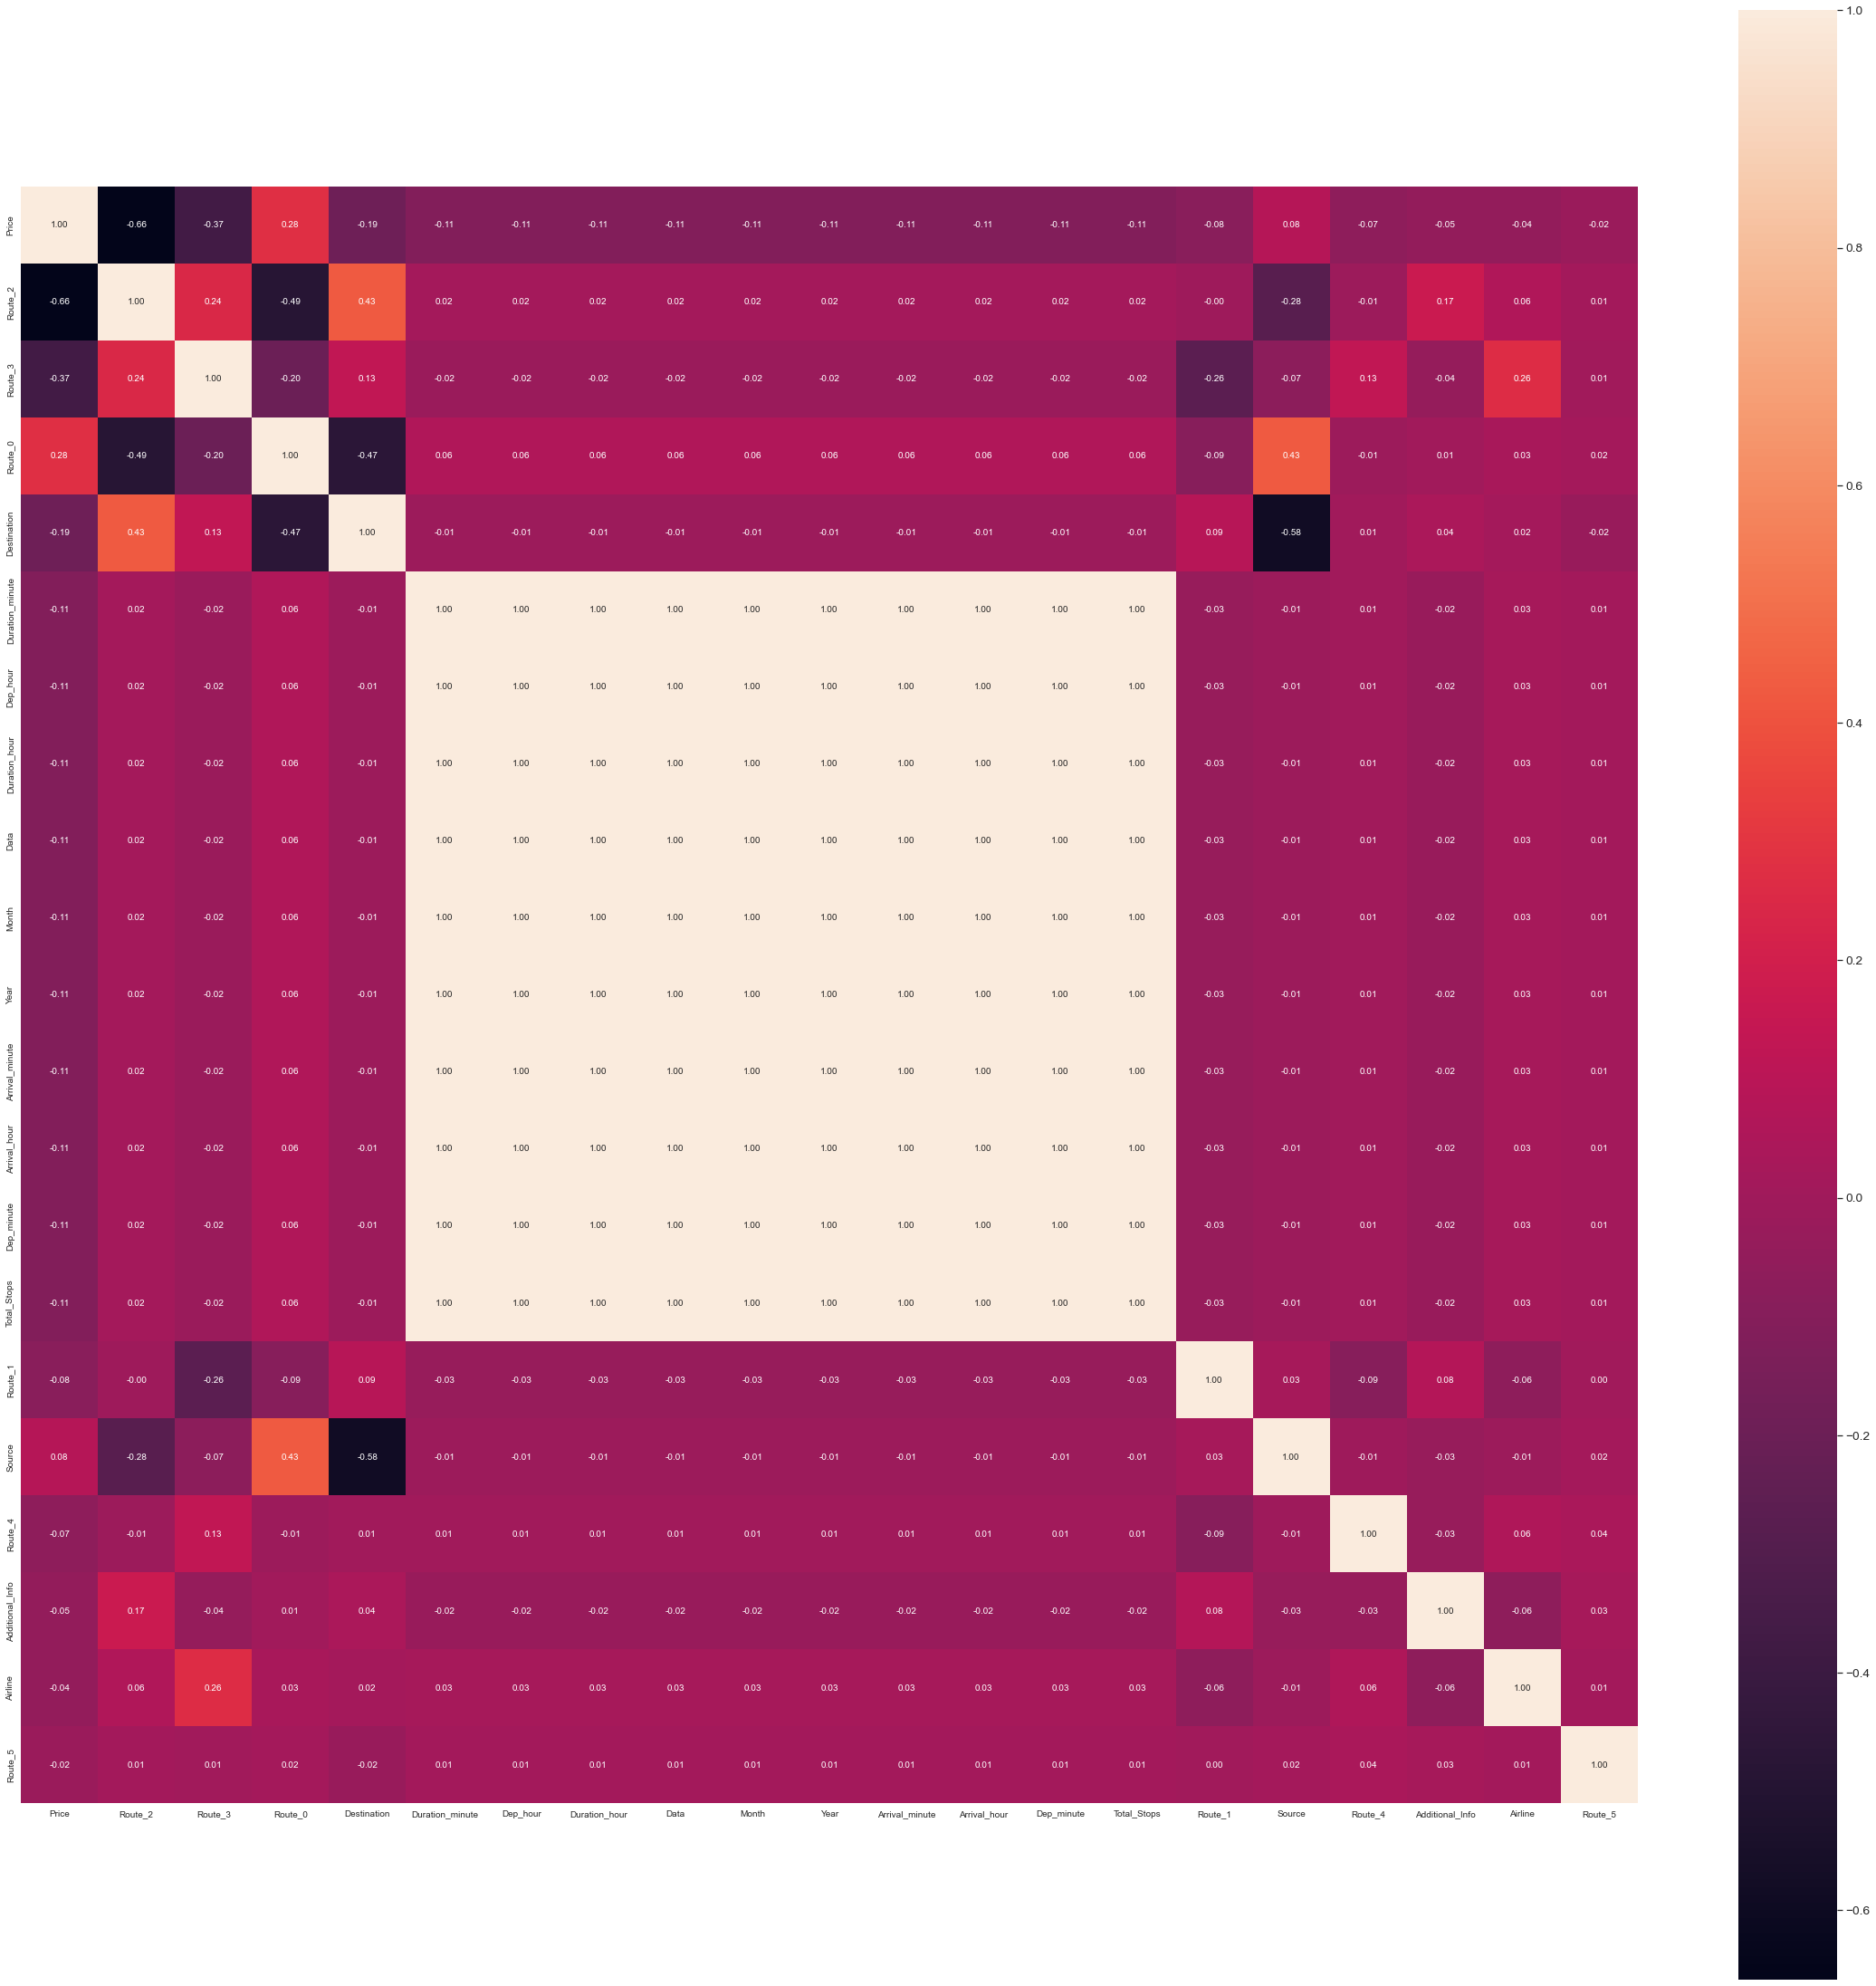

In [51]:
k = 21
f, ax = plt.subplots(figsize=(40, 40))
cols = df.corr().abs().nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<Figure size 3960x2520 with 0 Axes>

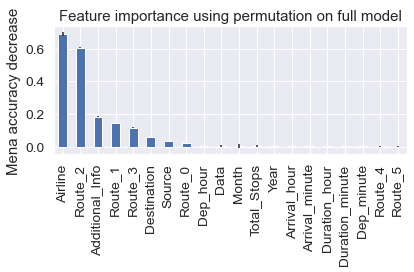

In [56]:
# Спомощью permutation_importance, могу увидеть самые опетитные фичи и отделить их от гадости
x_train, x_test, y_train, y_test = train_test_split(df.drop(['Price'], axis=1), df['Price'], test_size=0.44)

forest = RandomForestRegressor()
forest.fit(x_train, y_train)
feature_names = x_train.columns

result = permutation_importance(forest, x_train, y_train, n_repeats=30, n_jobs=-1)

forest_importance = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(55, 35))
fig, ax = plt.subplots()
forest_importance.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title('Feature importance using permutation on full model')
ax.set_ylabel('Mena accuracy decrease')
fig.tight_layout()
plt.show();

In [73]:
df_model = df[forest_importance[forest_importance > 0.003].index]
df_model['Price'] = df['Price']

C:\Users\Alex2\AppData\Local\Temp\ipykernel_10416\2689491217.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Price'] = df['Price']
